In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pickle
import optuna as optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance

c:\Documents\Capstone\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "../../Dataset/Yfinance/"
x_train = pd.read_csv(path + "X_train_winsorized.csv")
y_train = pd.read_csv(path + "Y_train_winsorized.csv")
x_validation = pd.read_csv(path + "X_validation.csv")
y_validation = pd.read_csv(path + "Y_validation.csv")
x_test = pd.read_csv(path + "X_test.csv")
y_test = pd.read_csv(path + "Y_test.csv")

In [3]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_validation.shape, y_validation.shape

((428514, 52), (428514, 1), (33628, 52), (33628, 1), (52797, 52), (52797, 1))

In [4]:
x_train = x_train.drop(columns=['StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey','day'])
x_test = x_test.drop(columns=['StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey','day'])
x_validation = x_validation.drop(columns=['StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey','day'])

In [5]:
x_train.columns

Index(['StkIndx', 'STInt', 'dtdlevel', 'dtdtrend', 'liqnonfinlevel',
       'liqnonfintrend', 'ni2talevel', 'ni2tatrend', 'sizelevel', 'sizetrend',
       'm2b', 'sigma', 'liqfinlevel', 'lqfintrend', 'DTDmedianFin',
       'DTDmedianNonFin', 'current_ratio', 'quick_ratio', 'cash_ratio',
       'net_working_capital', 'debt_ratio', 'debt_to_equity_ratio',
       'equity_ratio', 'cashflow_to_debt_ratio', 'net_profit_margin',
       'return_on_assets', 'asset_turnover', 'inventory_turnover',
       'days_in_inventory', 'receivables_turnover', 'day_sales_outstanding',
       'working_capital_turnover', 'price_to_earnings',
       'dividend_payout_ratio', 'retention_ratio', 'gross_margin_ratio',
       'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 'interest_coverage_ratio',
       'Rolling_Sortino', 'macd', 'macd_h', 'macd_s', 'rsi'],
      dtype='object')

In [6]:
# mini sample to try:
msk = np.random.rand(len(x_train)) < 0.0001
x_train_sample=x_train[msk]
y_train_sample=y_train[msk]

In [7]:
# WARNING: 2 changes to change evaluation metric
optimisation_metric = "auc" #"accuracy" "recall" "precision" "f1" "auc"
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'binary',
        'metric': 'auc', #"accuracy" "recall" "precision" "f1" "auc"
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        # 'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 10.0, log=True),
        'scale_pos_weight': 100,
        'max_depth': trial.suggest_int('max_depth', 2, 256),
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 500),
    }
    
    # full data
    gbm = lgb.train(param, lgb.Dataset(x_train, y_train))
    
    preds = gbm.predict(x_validation)
    y_pred_binary = np.round(preds)
    
    auc = roc_auc_score(y_validation, preds)
    accuracy = accuracy_score(y_validation, y_pred_binary)
    recall = recall_score(y_validation, y_pred_binary)
    precision = precision_score(y_validation, y_pred_binary)
    f1 = f1_score(y_validation, y_pred_binary)
    
    #choose the metric you want to optimized
    if optimisation_metric == 'recall': 
        return recall
    elif optimisation_metric == 'precision': 
        return precision
    elif optimisation_metric == 'f1':
        return f1
    elif optimisation_metric == 'auc':
        return auc
    elif optimisation_metric == 'accuracy': 
        return accuracy
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-11-06 21:17:42,314] A new study created in memory with name: no-name-7ad470fc-38e4-43f5-bfae-965e81824eae
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requiremen

[I 2023-11-06 21:17:52,923] Trial 0 finished with value: 0.2391622821180061 and parameters: {'num_leaves': 246, 'lambda_l1': 1.1572744808010245e-06, 'lambda_l2': 0.001283458351307692, 'feature_fraction': 0.9091703793964946, 'min_child_samples': 52, 'learning_rate': 7.5336052001444385, 'max_depth': 69, 'num_boost_round': 280}. Best is trial 0 with value: 0.2391622821180061.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:18:36,110] Trial 1 finished with value: 0.9184494209863177 and parameters: {'num_leaves': 128, 'lambda_l1': 3.3303240671701515e-08, 'lambda_l2': 1.6964827024869597e-08, 'feature_fraction': 0.5921907301942249, 'min_child_samples': 92, 'learning_rate': 2.0226326664382854e-06, 'max_depth': 31, 'num_boost_round': 298}. Best is trial 1 with value: 0.9184494209863177.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:19:37,470] Trial 2 finished with value: 0.8650511266865476 and parameters: {'num_leaves': 175, 'lambda_l1': 7.908371120701799e-05, 'lambda_l2': 0.11009805306963619, 'feature_fraction': 0.863114752375491, 'min_child_samples': 39, 'learning_rate': 0.0022168491368634744, 'max_depth': 80, 'num_boost_round': 312}. Best is trial 1 with value: 0.9184494209863177.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:20:15,310] Trial 3 finished with value: 0.9059213250517599 and parameters: {'num_leaves': 208, 'lambda_l1': 3.844445418500312, 'lambda_l2': 0.8211996439124091, 'feature_fraction': 0.8375731904820971, 'min_child_samples': 42, 'learning_rate': 3.2515923383351475e-06, 'max_depth': 106, 'num_boost_round': 283}. Best is trial 1 with value: 0.9184494209863177.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2023-11-06 21:20:52,806] Trial 4 finished with value: 0.8428409342729246 and parameters: {'num_leaves': 213, 'lambda_l1': 0.0004506946194337452, 'lambda_l2': 0.0013200563774938652, 'feature_fraction': 0.601290282395781, 'min_child_samples': 26, 'learning_rate': 0.0072504404445828795, 'max_depth': 26, 'num_boost_round': 186}. Best is trial 1 with value: 0.9184494209863177.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2023-11-06 21:21:01,931] Trial 5 finished with value: 0.7482416851862403 and parameters: {'num_leaves': 190, 'lambda_l1': 2.4698294555060758e-08, 'lambda_l2': 5.550995282092869e-05, 'feature_fraction': 0.9063878208910721, 'min_child_samples': 25, 'learning_rate': 0.19845801874368818, 'max_depth': 70, 'num_boost_round': 289}. Best is trial 1 with value: 0.9184494209863177.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:21:20,994] Trial 6 finished with value: 0.8855432724878277 and parameters: {'num_leaves': 129, 'lambda_l1': 1.314366553981709e-05, 'lambda_l2': 6.98295063074595e-06, 'feature_fraction': 0.8689720729526834, 'min_child_samples': 35, 'learning_rate': 1.5505203122613348e-07, 'max_depth': 143, 'num_boost_round': 144}. Best is trial 1 with value: 0.9184494209863177.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:21:51,511] Trial 7 finished with value: 0.9152335365737838 and parameters: {'num_leaves': 185, 'lambda_l1': 0.024254350102711278, 'lambda_l2': 0.0017716221616626085, 'feature_fraction': 0.6287546124676844, 'min_child_samples': 100, 'learning_rate': 3.383992088123649e-05, 'max_depth': 58, 'num_boost_round': 143}. Best is trial 1 with value: 0.9184494209863177.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2023-11-06 21:21:55,271] Trial 8 finished with value: 0.707206678443216 and parameters: {'num_leaves': 218, 'lambda_l1': 0.19238123980750074, 'lambda_l2': 0.03081670599668524, 'feature_fraction': 0.6472113821122951, 'min_child_samples': 77, 'learning_rate': 8.733502008932428, 'max_depth': 212, 'num_boost_round': 137}. Best is trial 1 with value: 0.9184494209863177.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


[I 2023-11-06 21:22:47,408] Trial 9 finished with value: 0.839976446901058 and parameters: {'num_leaves': 110, 'lambda_l1': 0.005076689527940899, 'lambda_l2': 0.059371663052295146, 'feature_fraction': 0.7421972922996312, 'min_child_samples': 22, 'learning_rate': 0.00260446402572429, 'max_depth': 246, 'num_boost_round': 290}. Best is trial 1 with value: 0.9184494209863177.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:23:15,899] Trial 10 finished with value: 0.932108635503131 and parameters: {'num_leaves': 37, 'lambda_l1': 1.3721691682073158e-08, 'lambda_l2': 1.2312562502716435e-08, 'feature_fraction': 0.4479696718983869, 'min_child_samples': 76, 'learning_rate': 1.8758865353557474e-08, 'max_depth': 2, 'num_boost_round': 488}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:25:31,635] Trial 11 finished with value: 0.9219993541892225 and parameters: {'num_leaves': 26, 'lambda_l1': 1.1833844779574001e-08, 'lambda_l2': 1.856066822743487e-08, 'feature_fraction': 0.4417281574959462, 'min_child_samples': 77, 'learning_rate': 1.0062335138742897e-08, 'max_depth': 5, 'num_boost_round': 487}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:28:05,517] Trial 12 finished with value: 0.9258728892434517 and parameters: {'num_leaves': 8, 'lambda_l1': 5.248639180134218e-07, 'lambda_l2': 1.1907740582442742e-08, 'feature_fraction': 0.441110705893891, 'min_child_samples': 73, 'learning_rate': 2.146279164246437e-08, 'max_depth': 5, 'num_boost_round': 493}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.512728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:28:48,964] Trial 13 finished with value: 0.9306415053722592 and parameters: {'num_leaves': 4, 'lambda_l1': 7.530532362127235e-07, 'lambda_l2': 4.884160634008829e-07, 'feature_fraction': 0.4071173259505995, 'min_child_samples': 70, 'learning_rate': 1.9195784522667132e-08, 'max_depth': 162, 'num_boost_round': 470}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:30:14,803] Trial 14 finished with value: 0.9271852147320835 and parameters: {'num_leaves': 55, 'lambda_l1': 7.611552074875091e-07, 'lambda_l2': 6.977933694183523e-07, 'feature_fraction': 0.40542330846384905, 'min_child_samples': 63, 'learning_rate': 2.6783435414875736e-07, 'max_depth': 161, 'num_boost_round': 419}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:33:42,165] Trial 15 finished with value: 0.9022123451162143 and parameters: {'num_leaves': 81, 'lambda_l1': 1.5115737958916378e-07, 'lambda_l2': 3.930577653339915e-07, 'feature_fraction': 0.5253493770402924, 'min_child_samples': 62, 'learning_rate': 3.868087317681074e-05, 'max_depth': 183, 'num_boost_round': 418}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.398503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:35:58,334] Trial 16 finished with value: 0.9244186120133467 and parameters: {'num_leaves': 48, 'lambda_l1': 1.0404511603972737e-05, 'lambda_l2': 3.219682789319703e-07, 'feature_fraction': 0.5106708024967384, 'min_child_samples': 89, 'learning_rate': 1.2632235184132602e-08, 'max_depth': 112, 'num_boost_round': 421}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:36:15,467] Trial 17 finished with value: 0.925663633888604 and parameters: {'num_leaves': 3, 'lambda_l1': 1.2249139498701198e-07, 'lambda_l2': 4.142152156428468e-06, 'feature_fraction': 0.4016537408086343, 'min_child_samples': 11, 'learning_rate': 1.3179087274758223e-07, 'max_depth': 186, 'num_boost_round': 372}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:36:58,733] Trial 18 finished with value: 0.9262723422037342 and parameters: {'num_leaves': 74, 'lambda_l1': 1.2081018560667886e-08, 'lambda_l2': 1.1767301578196037e-07, 'feature_fraction': 0.5226832908794042, 'min_child_samples': 64, 'learning_rate': 9.719144674680232e-07, 'max_depth': 136, 'num_boost_round': 458}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:37:06,236] Trial 19 finished with value: 0.9055506803173337 and parameters: {'num_leaves': 31, 'lambda_l1': 3.38357655703172e-06, 'lambda_l2': 3.0922357414154525e-06, 'feature_fraction': 0.49225535188229236, 'min_child_samples': 51, 'learning_rate': 1.2073621326874016e-05, 'max_depth': 254, 'num_boost_round': 351}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:37:15,780] Trial 20 finished with value: 0.9104808757700659 and parameters: {'num_leaves': 93, 'lambda_l1': 1.5369042973780354e-07, 'lambda_l2': 4.480319319611603e-05, 'feature_fraction': 0.9759875592032605, 'min_child_samples': 84, 'learning_rate': 6.250981809244106e-08, 'max_depth': 212, 'num_boost_round': 217}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:37:24,751] Trial 21 finished with value: 0.9249458975186936 and parameters: {'num_leaves': 44, 'lambda_l1': 5.823914553767255e-07, 'lambda_l2': 1.848551504324871e-07, 'feature_fraction': 0.4324773969499009, 'min_child_samples': 63, 'learning_rate': 3.256759912148712e-07, 'max_depth': 163, 'num_boost_round': 438}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:37:34,158] Trial 22 finished with value: 0.9286889408070103 and parameters: {'num_leaves': 66, 'lambda_l1': 2.4958989492972035e-06, 'lambda_l2': 9.248196025924362e-07, 'feature_fraction': 0.4183823847454712, 'min_child_samples': 69, 'learning_rate': 7.645830801371822e-08, 'max_depth': 162, 'num_boost_round': 393}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:37:41,187] Trial 23 finished with value: 0.9123727214592791 and parameters: {'num_leaves': 21, 'lambda_l1': 4.390477840333426e-06, 'lambda_l2': 1.1230260480967619e-07, 'feature_fraction': 0.49031827186098603, 'min_child_samples': 72, 'learning_rate': 5.3425853928486475e-08, 'max_depth': 200, 'num_boost_round': 378}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:37:52,512] Trial 24 finished with value: 0.9275656099429533 and parameters: {'num_leaves': 58, 'lambda_l1': 3.6475690318760555e-05, 'lambda_l2': 3.523313480804838e-08, 'feature_fraction': 0.4652857295254905, 'min_child_samples': 83, 'learning_rate': 1.0454573219111604e-08, 'max_depth': 103, 'num_boost_round': 464}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:38:07,006] Trial 25 finished with value: 0.9245257406246636 and parameters: {'num_leaves': 152, 'lambda_l1': 1.075534506237515e-07, 'lambda_l2': 8.31145867036139e-07, 'feature_fraction': 0.5460658151604716, 'min_child_samples': 69, 'learning_rate': 7.239114696538411e-07, 'max_depth': 160, 'num_boost_round': 393}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:38:18,035] Trial 26 finished with value: 0.9300812328654371 and parameters: {'num_leaves': 71, 'lambda_l1': 1.8383467643915184e-06, 'lambda_l2': 6.636812646130469e-08, 'feature_fraction': 0.4009610996661111, 'min_child_samples': 56, 'learning_rate': 7.735794575641152e-08, 'max_depth': 130, 'num_boost_round': 463}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:38:28,664] Trial 27 finished with value: 0.9221223114960649 and parameters: {'num_leaves': 35, 'lambda_l1': 5.849648366601923e-08, 'lambda_l2': 5.4340627191758234e-08, 'feature_fraction': 0.46909394154772255, 'min_child_samples': 57, 'learning_rate': 5.590901983361861e-08, 'max_depth': 123, 'num_boost_round': 500}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:38:42,259] Trial 28 finished with value: 0.9286405683134842 and parameters: {'num_leaves': 94, 'lambda_l1': 4.5333703632098065e-07, 'lambda_l2': 6.066720966891519e-08, 'feature_fraction': 0.462709482147764, 'min_child_samples': 47, 'learning_rate': 4.927329766752759e-07, 'max_depth': 45, 'num_boost_round': 455}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:38:49,811] Trial 29 finished with value: 0.9021426988559018 and parameters: {'num_leaves': 15, 'lambda_l1': 1.7739527145037323e-06, 'lambda_l2': 1.0108531224277421e-08, 'feature_fraction': 0.5542259601256134, 'min_child_samples': 54, 'learning_rate': 4.2878340525502675e-06, 'max_depth': 88, 'num_boost_round': 347}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:38:55,778] Trial 30 finished with value: 0.9267455568851659 and parameters: {'num_leaves': 39, 'lambda_l1': 1.002721480767336e-08, 'lambda_l2': 6.16380950878565e-08, 'feature_fraction': 0.4015234362114391, 'min_child_samples': 99, 'learning_rate': 2.5458499486206235e-08, 'max_depth': 139, 'num_boost_round': 245}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:39:08,233] Trial 31 finished with value: 0.9279372677138932 and parameters: {'num_leaves': 61, 'lambda_l1': 1.6292466744846281e-06, 'lambda_l2': 9.76716596745752e-07, 'feature_fraction': 0.4404772464521663, 'min_child_samples': 68, 'learning_rate': 1.0338901689234919e-07, 'max_depth': 150, 'num_boost_round': 462}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:39:20,662] Trial 32 finished with value: 0.9284969703876764 and parameters: {'num_leaves': 74, 'lambda_l1': 4.605043085843484e-08, 'lambda_l2': 1.9023774213494696e-07, 'feature_fraction': 0.48728699121013624, 'min_child_samples': 79, 'learning_rate': 6.022913953656917e-08, 'max_depth': 178, 'num_boost_round': 403}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:39:34,018] Trial 33 finished with value: 0.9290977010402619 and parameters: {'num_leaves': 110, 'lambda_l1': 2.738961868750229e-07, 'lambda_l2': 3.5443148733337756e-08, 'feature_fraction': 0.4028093900427118, 'min_child_samples': 58, 'learning_rate': 1.781628186709031e-06, 'max_depth': 229, 'num_boost_round': 475}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:39:48,385] Trial 34 finished with value: 0.9288905350732235 and parameters: {'num_leaves': 114, 'lambda_l1': 3.1777212823187803e-07, 'lambda_l2': 1.0780744947341933e-08, 'feature_fraction': 0.44664846485086573, 'min_child_samples': 45, 'learning_rate': 1.4092166771135234e-06, 'max_depth': 231, 'num_boost_round': 482}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:40:09,621] Trial 35 finished with value: 0.9242034683837635 and parameters: {'num_leaves': 253, 'lambda_l1': 3.803192807048771e-08, 'lambda_l2': 3.654789734300843e-08, 'feature_fraction': 0.5570952102742504, 'min_child_samples': 57, 'learning_rate': 3.4307852902987764e-07, 'max_depth': 123, 'num_boost_round': 443}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:40:29,770] Trial 36 finished with value: 0.9302186259425989 and parameters: {'num_leaves': 144, 'lambda_l1': 2.9858958796975173e-07, 'lambda_l2': 3.194513692312174e-08, 'feature_fraction': 0.4022895016273801, 'min_child_samples': 36, 'learning_rate': 3.3959405458085094e-06, 'max_depth': 90, 'num_boost_round': 473}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:40:44,635] Trial 37 finished with value: 0.9300028491651946 and parameters: {'num_leaves': 172, 'lambda_l1': 0.00012754566749622617, 'lambda_l2': 1.9297078643223885e-07, 'feature_fraction': 0.47446051370142306, 'min_child_samples': 38, 'learning_rate': 3.093308952582659e-08, 'max_depth': 91, 'num_boost_round': 320}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:41:03,676] Trial 38 finished with value: 0.929722997828303 and parameters: {'num_leaves': 146, 'lambda_l1': 3.9722509837670107e-08, 'lambda_l2': 1.892842926984919e-06, 'feature_fraction': 0.43654638419374253, 'min_child_samples': 32, 'learning_rate': 1.8587576769820832e-07, 'max_depth': 42, 'num_boost_round': 430}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:41:29,851] Trial 39 finished with value: 0.9280052677898709 and parameters: {'num_leaves': 162, 'lambda_l1': 1.283138470482346e-05, 'lambda_l2': 1.018089030741658e-05, 'feature_fraction': 0.507707011799537, 'min_child_samples': 49, 'learning_rate': 5.086847026110823e-06, 'max_depth': 74, 'num_boost_round': 448}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:41:49,996] Trial 40 finished with value: 0.9246638934792105 and parameters: {'num_leaves': 139, 'lambda_l1': 8.246416371127669e-07, 'lambda_l2': 3.514165363992161e-07, 'feature_fraction': 0.5717708680288816, 'min_child_samples': 42, 'learning_rate': 5.5849121207712e-07, 'max_depth': 25, 'num_boost_round': 472}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:42:05,491] Trial 41 finished with value: 0.9271101234005102 and parameters: {'num_leaves': 174, 'lambda_l1': 0.00015263587310843728, 'lambda_l2': 9.363038451793066e-08, 'feature_fraction': 0.4818739677304653, 'min_child_samples': 37, 'learning_rate': 3.951230663542289e-08, 'max_depth': 92, 'num_boost_round': 318}. Best is trial 10 with value: 0.932108635503131.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:42:18,421] Trial 42 finished with value: 0.9356321664418992 and parameters: {'num_leaves': 220, 'lambda_l1': 0.0004701790364808825, 'lambda_l2': 1.9229153765136683e-07, 'feature_fraction': 0.45849539450475474, 'min_child_samples': 32, 'learning_rate': 2.6809525393339873e-08, 'max_depth': 63, 'num_boost_round': 244}. Best is trial 42 with value: 0.9356321664418992.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:42:29,203] Trial 43 finished with value: 0.9257498686218272 and parameters: {'num_leaves': 238, 'lambda_l1': 0.0005855123704540557, 'lambda_l2': 3.3729640913874087e-08, 'feature_fraction': 0.42591340613920065, 'min_child_samples': 19, 'learning_rate': 2.1040414387186213e-08, 'max_depth': 65, 'num_boost_round': 258}. Best is trial 42 with value: 0.9356321664418992.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:42:36,767] Trial 44 finished with value: 0.926700983278566 and parameters: {'num_leaves': 198, 'lambda_l1': 5.054266535194551e-05, 'lambda_l2': 2.5333783938155627e-08, 'feature_fraction': 0.45047921227124205, 'min_child_samples': 31, 'learning_rate': 1.64161206967509e-07, 'max_depth': 20, 'num_boost_round': 191}. Best is trial 42 with value: 0.9356321664418992.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:42:39,161] Trial 45 finished with value: 0.9147270183169665 and parameters: {'num_leaves': 15, 'lambda_l1': 0.0006346242643831996, 'lambda_l2': 1.8200659151335528e-08, 'feature_fraction': 0.42193399720109886, 'min_child_samples': 16, 'learning_rate': 1.4098307614727447e-08, 'max_depth': 59, 'num_boost_round': 105}. Best is trial 42 with value: 0.9356321664418992.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:42:50,037] Trial 46 finished with value: 0.9310042357589227 and parameters: {'num_leaves': 232, 'lambda_l1': 7.250179896110915e-06, 'lambda_l2': 4.032972746661027e-07, 'feature_fraction': 0.4611835235627013, 'min_child_samples': 27, 'learning_rate': 1.7455863084900048e-07, 'max_depth': 109, 'num_boost_round': 260}. Best is trial 42 with value: 0.9356321664418992.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:43:02,692] Trial 47 finished with value: 0.9066483053798571 and parameters: {'num_leaves': 224, 'lambda_l1': 4.451998650288021e-06, 'lambda_l2': 9.665724630190136e-06, 'feature_fraction': 0.5988024496781527, 'min_child_samples': 25, 'learning_rate': 2.1910702298186808e-07, 'max_depth': 110, 'num_boost_round': 266}. Best is trial 42 with value: 0.9356321664418992.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:43:17,536] Trial 48 finished with value: 0.910390462261224 and parameters: {'num_leaves': 240, 'lambda_l1': 2.069412507546909e-08, 'lambda_l2': 5.107401026961676e-07, 'feature_fraction': 0.5202547180893851, 'min_child_samples': 6, 'learning_rate': 2.7543922162383614e-08, 'max_depth': 43, 'num_boost_round': 226}. Best is trial 42 with value: 0.9356321664418992.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:43:27,176] Trial 49 finished with value: 0.9268506594234557 and parameters: {'num_leaves': 205, 'lambda_l1': 2.3959883269875374e-05, 'lambda_l2': 1.9662916340518486e-06, 'feature_fraction': 0.46286963044649837, 'min_child_samples': 29, 'learning_rate': 5.931235411863032e-07, 'max_depth': 79, 'num_boost_round': 181}. Best is trial 42 with value: 0.9356321664418992.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:43:43,956] Trial 50 finished with value: 0.9224963752287246 and parameters: {'num_leaves': 223, 'lambda_l1': 7.677916823614484e-06, 'lambda_l2': 2.429920364362587e-07, 'feature_fraction': 0.5030091669901797, 'min_child_samples': 22, 'learning_rate': 1.1407481995009595e-08, 'max_depth': 98, 'num_boost_round': 230}. Best is trial 42 with value: 0.9356321664418992.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:44:02,392] Trial 51 finished with value: 0.9369591176451967 and parameters: {'num_leaves': 188, 'lambda_l1': 7.88574953781686e-07, 'lambda_l2': 8.837552706988236e-08, 'feature_fraction': 0.4270999518652859, 'min_child_samples': 41, 'learning_rate': 1.3778299709042474e-07, 'max_depth': 118, 'num_boost_round': 278}. Best is trial 51 with value: 0.9369591176451967.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:44:17,837] Trial 52 finished with value: 0.9331675752337899 and parameters: {'num_leaves': 194, 'lambda_l1': 1.0040528765796632e-06, 'lambda_l2': 1.2024647821108627e-07, 'feature_fraction': 0.42762682078447783, 'min_child_samples': 34, 'learning_rate': 1.2581286429704117e-07, 'max_depth': 119, 'num_boost_round': 287}. Best is trial 51 with value: 0.9369591176451967.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:44:31,640] Trial 53 finished with value: 0.9335891250530262 and parameters: {'num_leaves': 187, 'lambda_l1': 8.204484617634322e-07, 'lambda_l2': 1.3215865576815214e-07, 'feature_fraction': 0.4471992940639288, 'min_child_samples': 42, 'learning_rate': 1.5837735366737662e-07, 'max_depth': 120, 'num_boost_round': 301}. Best is trial 51 with value: 0.9369591176451967.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:44:47,477] Trial 54 finished with value: 0.9254016373202653 and parameters: {'num_leaves': 187, 'lambda_l1': 1.1462565732083632e-06, 'lambda_l2': 1.8689320379390434e-07, 'feature_fraction': 0.5321675678825762, 'min_child_samples': 42, 'learning_rate': 1.354698749033032e-07, 'max_depth': 119, 'num_boost_round': 295}. Best is trial 51 with value: 0.9369591176451967.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:45:01,376] Trial 55 finished with value: 0.9320186651977638 and parameters: {'num_leaves': 209, 'lambda_l1': 1.7517933866639687e-05, 'lambda_l2': 1.001368522452008e-07, 'feature_fraction': 0.4573251818672315, 'min_child_samples': 33, 'learning_rate': 1.1587870013927736e-06, 'max_depth': 131, 'num_boost_round': 274}. Best is trial 51 with value: 0.9369591176451967.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:45:18,651] Trial 56 finished with value: 0.9276455131979664 and parameters: {'num_leaves': 195, 'lambda_l1': 2.9324850675852506e-05, 'lambda_l2': 1.1387228101797312e-07, 'feature_fraction': 0.49381093430732803, 'min_child_samples': 33, 'learning_rate': 1.1309512362250202e-06, 'max_depth': 15, 'num_boost_round': 276}. Best is trial 51 with value: 0.9369591176451967.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:45:37,161] Trial 57 finished with value: 0.8754427286138495 and parameters: {'num_leaves': 210, 'lambda_l1': 4.122525909702465e-06, 'lambda_l2': 1.7119076920412348e-08, 'feature_fraction': 0.6351113303361431, 'min_child_samples': 41, 'learning_rate': 3.8443432201805495e-08, 'max_depth': 132, 'num_boost_round': 332}. Best is trial 51 with value: 0.9369591176451967.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:45:48,144] Trial 58 finished with value: 0.9347894466921192 and parameters: {'num_leaves': 181, 'lambda_l1': 1.4543241339120504e-07, 'lambda_l2': 1.0192531016294772e-08, 'feature_fraction': 0.43178520228727446, 'min_child_samples': 45, 'learning_rate': 3.584973038411817e-07, 'max_depth': 118, 'num_boost_round': 281}. Best is trial 51 with value: 0.9369591176451967.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:45:55,965] Trial 59 finished with value: 0.9369688681216404 and parameters: {'num_leaves': 181, 'lambda_l1': 7.257323877795732e-08, 'lambda_l2': 1.0713451728031349e-08, 'feature_fraction': 0.42271125685727073, 'min_child_samples': 45, 'learning_rate': 3.136147415070856e-07, 'max_depth': 145, 'num_boost_round': 210}. Best is trial 59 with value: 0.9369688681216404.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:46:03,648] Trial 60 finished with value: 0.936335973559747 and parameters: {'num_leaves': 176, 'lambda_l1': 6.957121854193698e-08, 'lambda_l2': 1.83165045047931e-08, 'feature_fraction': 0.4281298346058461, 'min_child_samples': 45, 'learning_rate': 3.429760720167207e-07, 'max_depth': 147, 'num_boost_round': 205}. Best is trial 59 with value: 0.9369688681216404.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:46:11,474] Trial 61 finished with value: 0.9367786705162054 and parameters: {'num_leaves': 182, 'lambda_l1': 9.612367203572479e-08, 'lambda_l2': 1.0065507713964535e-08, 'feature_fraction': 0.434391179666989, 'min_child_samples': 51, 'learning_rate': 3.244293100491594e-07, 'max_depth': 117, 'num_boost_round': 196}. Best is trial 59 with value: 0.9369688681216404.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:46:19,284] Trial 62 finished with value: 0.9369660822712279 and parameters: {'num_leaves': 180, 'lambda_l1': 9.067485220302783e-08, 'lambda_l2': 1.0099338680505142e-08, 'feature_fraction': 0.42746174750078875, 'min_child_samples': 45, 'learning_rate': 4.172267093475828e-07, 'max_depth': 150, 'num_boost_round': 202}. Best is trial 59 with value: 0.9369688681216404.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:46:26,960] Trial 63 finished with value: 0.9373024103937546 and parameters: {'num_leaves': 165, 'lambda_l1': 8.741184942150511e-08, 'lambda_l2': 1.0128897367814743e-08, 'feature_fraction': 0.42413410967817455, 'min_child_samples': 51, 'learning_rate': 5.194958780945468e-07, 'max_depth': 152, 'num_boost_round': 197}. Best is trial 63 with value: 0.9373024103937546.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:46:34,471] Trial 64 finished with value: 0.9332425399357989 and parameters: {'num_leaves': 163, 'lambda_l1': 7.169504459199548e-08, 'lambda_l2': 1.999391971414317e-08, 'feature_fraction': 0.48217017430562426, 'min_child_samples': 52, 'learning_rate': 6.387316635403071e-07, 'max_depth': 149, 'num_boost_round': 198}. Best is trial 63 with value: 0.9373024103937546.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:46:40,502] Trial 65 finished with value: 0.9306349839497028 and parameters: {'num_leaves': 166, 'lambda_l1': 2.3674869303969995e-08, 'lambda_l2': 1.9779769742013906e-08, 'feature_fraction': 0.4144610286299613, 'min_child_samples': 48, 'learning_rate': 7.879269010444476e-06, 'max_depth': 170, 'num_boost_round': 167}. Best is trial 63 with value: 0.9373024103937546.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:46:47,812] Trial 66 finished with value: 0.9335967228268784 and parameters: {'num_leaves': 154, 'lambda_l1': 8.7581315371301e-08, 'lambda_l2': 5.040792071997638e-08, 'feature_fraction': 0.4234427201472833, 'min_child_samples': 50, 'learning_rate': 2.682493124338466e-06, 'max_depth': 150, 'num_boost_round': 205}. Best is trial 63 with value: 0.9373024103937546.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:46:54,219] Trial 67 finished with value: 0.9293174033341564 and parameters: {'num_leaves': 180, 'lambda_l1': 2.7443123191225026e-08, 'lambda_l2': 1.0647886049059403e-08, 'feature_fraction': 0.4736632769943724, 'min_child_samples': 46, 'learning_rate': 3.1696904393886025e-07, 'max_depth': 142, 'num_boost_round': 161}. Best is trial 63 with value: 0.9373024103937546.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:47:01,931] Trial 68 finished with value: 0.9317866798361414 and parameters: {'num_leaves': 156, 'lambda_l1': 2.1196128445490087e-07, 'lambda_l2': 6.067194812276288e-08, 'feature_fraction': 0.44103169322775526, 'min_child_samples': 54, 'learning_rate': 2.0503194320662162e-06, 'max_depth': 197, 'num_boost_round': 215}. Best is trial 63 with value: 0.9373024103937546.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:47:10,121] Trial 69 finished with value: 0.9294520105609057 and parameters: {'num_leaves': 131, 'lambda_l1': 8.145834567846309e-08, 'lambda_l2': 2.2248943987387492e-08, 'feature_fraction': 0.5084420691600864, 'min_child_samples': 60, 'learning_rate': 8.050887188790236e-08, 'max_depth': 155, 'num_boost_round': 232}. Best is trial 63 with value: 0.9373024103937546.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:47:17,155] Trial 70 finished with value: 0.9323687959427888 and parameters: {'num_leaves': 201, 'lambda_l1': 2.185078143114679e-07, 'lambda_l2': 3.616171023390913e-08, 'feature_fraction': 0.4209232443780253, 'min_child_samples': 40, 'learning_rate': 1.0068595488295632e-06, 'max_depth': 175, 'num_boost_round': 176}. Best is trial 63 with value: 0.9373024103937546.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:47:26,195] Trial 71 finished with value: 0.9329152025123305 and parameters: {'num_leaves': 179, 'lambda_l1': 1.303195394600792e-07, 'lambda_l2': 1.3431716236862781e-08, 'feature_fraction': 0.437817079354247, 'min_child_samples': 45, 'learning_rate': 3.1171150188851545e-07, 'max_depth': 138, 'num_boost_round': 244}. Best is trial 63 with value: 0.9373024103937546.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:47:34,815] Trial 72 finished with value: 0.9322272240900082 and parameters: {'num_leaves': 171, 'lambda_l1': 5.360524273746945e-08, 'lambda_l2': 1.1781984192331203e-08, 'feature_fraction': 0.45700597873159365, 'min_child_samples': 45, 'learning_rate': 4.0581222747383567e-07, 'max_depth': 146, 'num_boost_round': 214}. Best is trial 63 with value: 0.9373024103937546.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:47:44,753] Trial 73 finished with value: 0.9355869596874783 and parameters: {'num_leaves': 182, 'lambda_l1': 4.258025147047204e-07, 'lambda_l2': 2.3370297586125106e-08, 'feature_fraction': 0.42153797602231746, 'min_child_samples': 52, 'learning_rate': 8.869451776941192e-08, 'max_depth': 158, 'num_boost_round': 251}. Best is trial 63 with value: 0.9373024103937546.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:47:54,505] Trial 74 finished with value: 0.9346221690378053 and parameters: {'num_leaves': 215, 'lambda_l1': 4.402699347613753e-07, 'lambda_l2': 6.459774161591894e-08, 'feature_fraction': 0.4112381135159985, 'min_child_samples': 54, 'learning_rate': 7.523415617966323e-08, 'max_depth': 167, 'num_boost_round': 248}. Best is trial 63 with value: 0.9373024103937546.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:48:00,797] Trial 75 finished with value: 0.9305484959573512 and parameters: {'num_leaves': 188, 'lambda_l1': 2.0357134080961624e-08, 'lambda_l2': 2.6353189228857948e-08, 'feature_fraction': 0.47763825880497063, 'min_child_samples': 51, 'learning_rate': 1.0051872497999874e-07, 'max_depth': 155, 'num_boost_round': 151}. Best is trial 63 with value: 0.9373024103937546.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:48:07,906] Trial 76 finished with value: 0.9375806155463117 and parameters: {'num_leaves': 164, 'lambda_l1': 4.320315241170307e-07, 'lambda_l2': 5.162432762672246e-08, 'feature_fraction': 0.41749759302592937, 'min_child_samples': 66, 'learning_rate': 5.0439814387052354e-08, 'max_depth': 188, 'num_boost_round': 196}. Best is trial 76 with value: 0.9375806155463117.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:48:15,277] Trial 77 finished with value: 0.9334018399275679 and parameters: {'num_leaves': 166, 'lambda_l1': 1.8221419396423132e-07, 'lambda_l2': 4.732554268460626e-08, 'feature_fraction': 0.4388421805138381, 'min_child_samples': 39, 'learning_rate': 7.985241976641254e-07, 'max_depth': 194, 'num_boost_round': 201}. Best is trial 76 with value: 0.9375806155463117.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:48:20,147] Trial 78 finished with value: 0.931065777727126 and parameters: {'num_leaves': 135, 'lambda_l1': 5.931482479173833e-08, 'lambda_l2': 9.106955326960524e-08, 'feature_fraction': 0.4039355028423061, 'min_child_samples': 36, 'learning_rate': 2.046231356426505e-08, 'max_depth': 180, 'num_boost_round': 131}. Best is trial 76 with value: 0.9375806155463117.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:48:27,325] Trial 79 finished with value: 0.9360653661810422 and parameters: {'num_leaves': 157, 'lambda_l1': 1.4125701928341217e-08, 'lambda_l2': 4.0396527086971324e-08, 'feature_fraction': 0.45645657871108225, 'min_child_samples': 65, 'learning_rate': 4.715226257739347e-08, 'max_depth': 101, 'num_boost_round': 188}. Best is trial 76 with value: 0.9375806155463117.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:48:33,849] Trial 80 finished with value: 0.9344995916196553 and parameters: {'num_leaves': 118, 'lambda_l1': 1.0718389968811185e-08, 'lambda_l2': 4.4224049328147206e-08, 'feature_fraction': 0.49419127881764746, 'min_child_samples': 64, 'learning_rate': 1.988214316577201e-07, 'max_depth': 189, 'num_boost_round': 185}. Best is trial 76 with value: 0.9375806155463117.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:48:46,267] Trial 81 finished with value: 0.929918260616306 and parameters: {'num_leaves': 159, 'lambda_l1': 3.958940021993659e-08, 'lambda_l2': 1.8956102057721706e-08, 'feature_fraction': 0.45294357099498184, 'min_child_samples': 67, 'learning_rate': 5.160164895558543e-08, 'max_depth': 103, 'num_boost_round': 172}. Best is trial 76 with value: 0.9375806155463117.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:48:55,168] Trial 82 finished with value: 0.9358013435396761 and parameters: {'num_leaves': 149, 'lambda_l1': 9.616070525932776e-08, 'lambda_l2': 1.009443404848183e-08, 'feature_fraction': 0.4182901172907588, 'min_child_samples': 60, 'learning_rate': 4.272045262832363e-08, 'max_depth': 206, 'num_boost_round': 208}. Best is trial 76 with value: 0.9375806155463117.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:49:02,909] Trial 83 finished with value: 0.9378124742783698 and parameters: {'num_leaves': 170, 'lambda_l1': 8.485611894044479e-08, 'lambda_l2': 1.109604806379447e-08, 'feature_fraction': 0.4144368845658812, 'min_child_samples': 60, 'learning_rate': 4.764841303884443e-08, 'max_depth': 224, 'num_boost_round': 192}. Best is trial 83 with value: 0.9378124742783698.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:49:10,859] Trial 84 finished with value: 0.9354371569130244 and parameters: {'num_leaves': 172, 'lambda_l1': 1.691915336670982e-08, 'lambda_l2': 3.0729273012851185e-08, 'feature_fraction': 0.4335614080317213, 'min_child_samples': 66, 'learning_rate': 2.6984891439172116e-07, 'max_depth': 223, 'num_boost_round': 192}. Best is trial 83 with value: 0.9378124742783698.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:49:17,088] Trial 85 finished with value: 0.9316834767413147 and parameters: {'num_leaves': 167, 'lambda_l1': 3.4322977924802475e-08, 'lambda_l2': 1.6417788089519065e-08, 'feature_fraction': 0.4717564855174346, 'min_child_samples': 75, 'learning_rate': 4.5676771618068595e-07, 'max_depth': 250, 'num_boost_round': 152}. Best is trial 83 with value: 0.9378124742783698.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:49:28,982] Trial 86 finished with value: 0.9353792872021831 and parameters: {'num_leaves': 143, 'lambda_l1': 1.1483201440648696e-07, 'lambda_l2': 5.978338602432839e-08, 'feature_fraction': 0.41638513806655464, 'min_child_samples': 56, 'learning_rate': 5.3769848728992417e-08, 'max_depth': 128, 'num_boost_round': 225}. Best is trial 83 with value: 0.9378124742783698.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:49:35,982] Trial 87 finished with value: 0.9311392228743646 and parameters: {'num_leaves': 174, 'lambda_l1': 2.666259970124325e-07, 'lambda_l2': 3.1775667755076426e-08, 'feature_fraction': 0.44474358372005346, 'min_child_samples': 61, 'learning_rate': 1.9332769974906486e-06, 'max_depth': 98, 'num_boost_round': 135}. Best is trial 83 with value: 0.9378124742783698.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:49:43,181] Trial 88 finished with value: 0.9329553440841832 and parameters: {'num_leaves': 192, 'lambda_l1': 1.3685803066507711e-08, 'lambda_l2': 7.229128072551954e-08, 'feature_fraction': 0.4004982540901793, 'min_child_samples': 72, 'learning_rate': 1.0877582545086192e-07, 'max_depth': 214, 'num_boost_round': 161}. Best is trial 83 with value: 0.9378124742783698.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:49:51,062] Trial 89 finished with value: 0.934604061010124 and parameters: {'num_leaves': 202, 'lambda_l1': 5.105252227909476e-08, 'lambda_l2': 1.61606035917097e-08, 'feature_fraction': 0.4660817616590851, 'min_child_samples': 48, 'learning_rate': 2.2942832846629596e-07, 'max_depth': 170, 'num_boost_round': 185}. Best is trial 83 with value: 0.9378124742783698.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:49:58,321] Trial 90 finished with value: 0.9324323639840194 and parameters: {'num_leaves': 153, 'lambda_l1': 5.156020780215919e-07, 'lambda_l2': 3.8525708017230506e-08, 'feature_fraction': 0.4474058270388679, 'min_child_samples': 65, 'learning_rate': 6.811126351294645e-07, 'max_depth': 236, 'num_boost_round': 215}. Best is trial 83 with value: 0.9378124742783698.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:50:05,813] Trial 91 finished with value: 0.9359663418618345 and parameters: {'num_leaves': 159, 'lambda_l1': 8.972043286587663e-08, 'lambda_l2': 1.0057246067804965e-08, 'feature_fraction': 0.4163341267007533, 'min_child_samples': 59, 'learning_rate': 3.8913589062272133e-08, 'max_depth': 205, 'num_boost_round': 208}. Best is trial 83 with value: 0.9378124742783698.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:50:14,648] Trial 92 finished with value: 0.9385099499180074 and parameters: {'num_leaves': 176, 'lambda_l1': 2.846233064641715e-08, 'lambda_l2': 1.5942763634225584e-08, 'feature_fraction': 0.4278289200923796, 'min_child_samples': 55, 'learning_rate': 3.143519232758905e-08, 'max_depth': 218, 'num_boost_round': 194}. Best is trial 92 with value: 0.9385099499180074.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:50:22,769] Trial 93 finished with value: 0.9391760214257223 and parameters: {'num_leaves': 175, 'lambda_l1': 2.82127648713194e-08, 'lambda_l2': 2.4835303772409743e-08, 'feature_fraction': 0.42996392930681454, 'min_child_samples': 54, 'learning_rate': 1.5170374947081534e-08, 'max_depth': 238, 'num_boost_round': 191}. Best is trial 93 with value: 0.9391760214257223.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:50:32,366] Trial 94 finished with value: 0.9363116606834198 and parameters: {'num_leaves': 178, 'lambda_l1': 2.33814284860289e-08, 'lambda_l2': 2.0358381714102265e-08, 'feature_fraction': 0.432895821023073, 'min_child_samples': 57, 'learning_rate': 1.6304849086194808e-08, 'max_depth': 237, 'num_boost_round': 236}. Best is trial 93 with value: 0.9391760214257223.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:50:42,441] Trial 95 finished with value: 0.9379391038425742 and parameters: {'num_leaves': 185, 'lambda_l1': 3.253897898117792e-08, 'lambda_l2': 2.3336490872543275e-08, 'feature_fraction': 0.41341540210841776, 'min_child_samples': 53, 'learning_rate': 1.0313694915347242e-08, 'max_depth': 219, 'num_boost_round': 196}. Best is trial 93 with value: 0.9391760214257223.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:50:52,038] Trial 96 finished with value: 0.9377525784945011 and parameters: {'num_leaves': 184, 'lambda_l1': 3.238462531944512e-08, 'lambda_l2': 8.186671483355848e-08, 'feature_fraction': 0.41152731500875994, 'min_child_samples': 55, 'learning_rate': 1.1259239039010213e-08, 'max_depth': 222, 'num_boost_round': 196}. Best is trial 93 with value: 0.9391760214257223.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:50:59,847] Trial 97 finished with value: 0.9324033658138166 and parameters: {'num_leaves': 196, 'lambda_l1': 3.077607470357928e-08, 'lambda_l2': 2.344123675877716e-07, 'feature_fraction': 0.4114618465482383, 'min_child_samples': 55, 'learning_rate': 1.3051506999377967e-08, 'max_depth': 245, 'num_boost_round': 176}. Best is trial 93 with value: 0.9391760214257223.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:51:05,289] Trial 98 finished with value: 0.9338769540524627 and parameters: {'num_leaves': 185, 'lambda_l1': 1.7100281808440372e-07, 'lambda_l2': 7.173631951732648e-08, 'feature_fraction': 0.40270896150872887, 'min_child_samples': 62, 'learning_rate': 1.0876391664077038e-08, 'max_depth': 220, 'num_boost_round': 120}. Best is trial 93 with value: 0.9391760214257223.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:51:13,540] Trial 99 finished with value: 0.937740168797209 and parameters: {'num_leaves': 191, 'lambda_l1': 4.287407262068669e-08, 'lambda_l2': 1.5046020979635695e-07, 'feature_fraction': 0.40008405437167066, 'min_child_samples': 49, 'learning_rate': 2.4192719264813333e-08, 'max_depth': 223, 'num_boost_round': 221}. Best is trial 93 with value: 0.9391760214257223.


In [8]:
# WARNING: 1 changement to chose evaluation metric, should allign with previous cell
best_params['objective'] = 'binary'
best_params['metric'] = 'auc' #"accuracy" "recall" "precision" "f1" "auc"

gbm = lgb.train(best_params, lgb.Dataset(x_train, y_train))

c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


In [9]:
y_pred = gbm.predict(x_test)
y_pred_binary = np.round(y_pred)

In [10]:
best_params

{'num_leaves': 175,
 'lambda_l1': 2.82127648713194e-08,
 'lambda_l2': 2.4835303772409743e-08,
 'feature_fraction': 0.42996392930681454,
 'min_child_samples': 54,
 'learning_rate': 1.5170374947081534e-08,
 'max_depth': 238,
 'num_boost_round': 191,
 'objective': 'binary',
 'metric': 'auc'}

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9964612822647794
Recall: 0.0
Precision: 0.0
F1 Score: 0.0
AUC: 0.9434224494059166


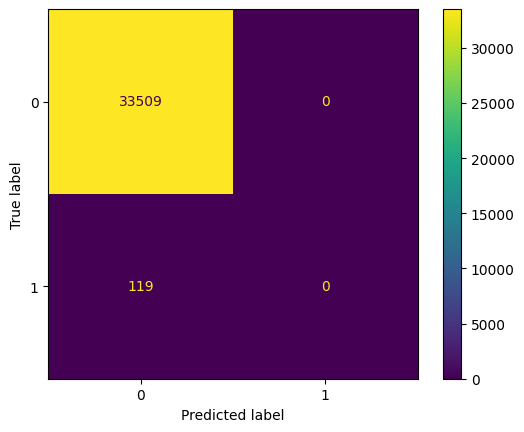

In [11]:
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)


ConfusionMatrixDisplay(confusion).plot()

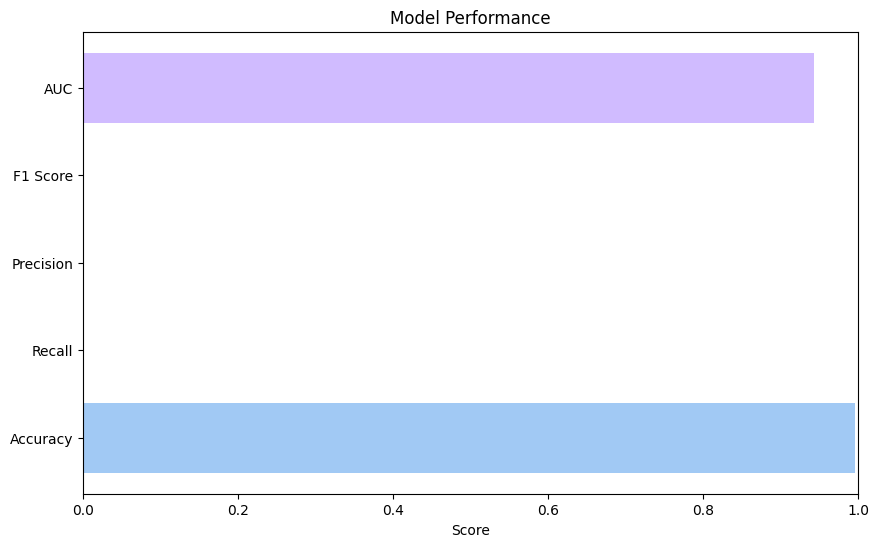

In [12]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [13]:
from sklearn.metrics import average_precision_score, auc

precision2, recall2, threshold = precision_recall_curve(y_test, y_pred_binary)
prauc = auc(precision2, recall2)
print("PRAUC: ", prauc)


PRAUC:  0.4982306411323897


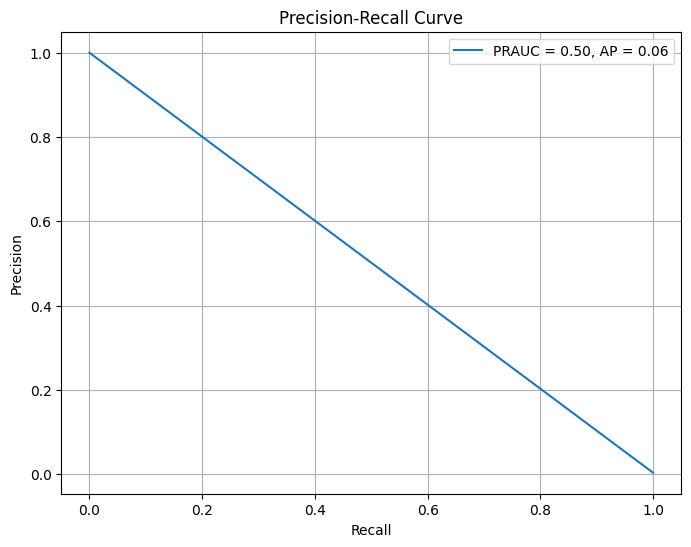

In [14]:
# Calculate the Average Precision (AP) to display in the plot
ap = average_precision_score(y_test, y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall2, precision2, label=f'PRAUC = {prauc:.2f}, AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [15]:
importance = pd.DataFrame({'feature': x_train.columns, 'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

                        feature  importance
19          net_working_capital        1544
20                   debt_ratio        1283
31     working_capital_turnover        1254
21         debt_to_equity_ratio        1188
15              DTDmedianNonFin        1186
26               asset_turnover        1131
10                          m2b        1110
25             return_on_assets        1019
6                    ni2talevel         983
22                 equity_ratio         969
11                        sigma         906
1                         STInt         902
8                     sizelevel         902
43                       macd_s         885
5                liqnonfintrend         875
42                       macd_h         868
17                  quick_ratio         853
41                         macd         845
4                liqnonfinlevel         834
28            days_in_inventory         832
38  debt_service_coverage_ratio         803
24            net_profit_margin 

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


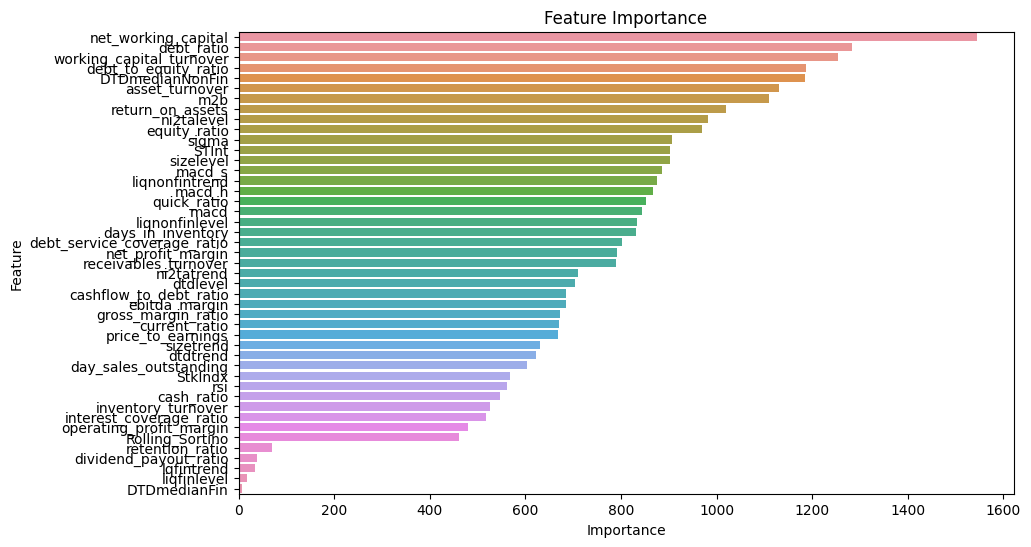

In [16]:
feature_importance = gbm.feature_importance()
features = x_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

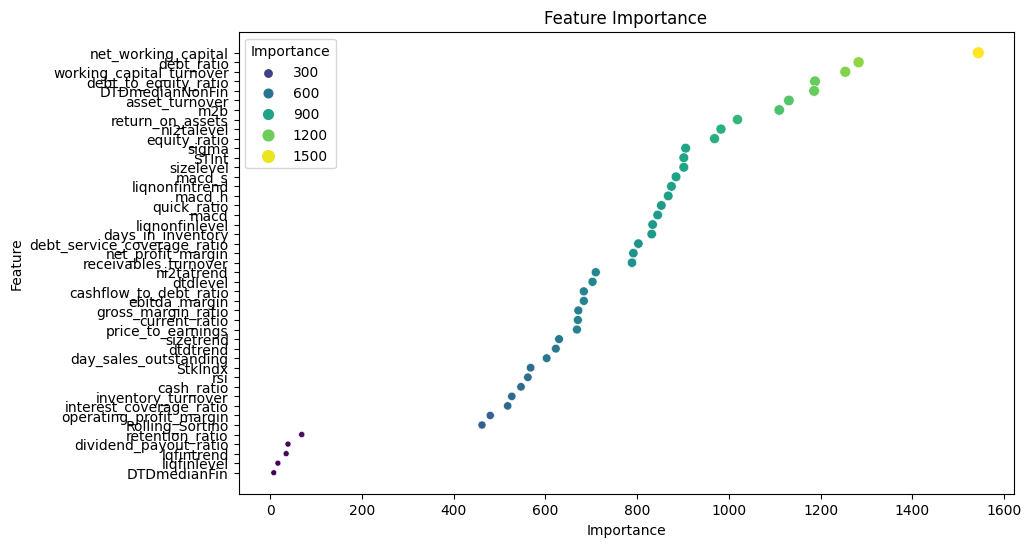

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False), size='Importance', hue='Importance', palette='viridis')
plt.title('Feature Importance')
plt.show()

In [18]:
#Precision OPTIMIZED
results = pd.DataFrame({'Recall': [recall], 'Precision': [precision], 'F1 Score': [f1], 'AUC': [auc]})
results.to_csv(path + 'LGB_yfinance_results_aucoptimized.csv', index=False)

best_params_df = pd.DataFrame(best_params, index=[0])
best_params_df.to_csv(path + 'best_params_lgb_yfinance_aucoptimized.csv', index=False)

gbm.save_model(path + 'model_lgb_yfinance_aucoptimize.txt')

Load one model and Plot performances

Accuracy: 0.9964612822647794
Recall: 0.0
Precision: 0.0
F1 Score: 0.0
AUC: 0.9434224494059166


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


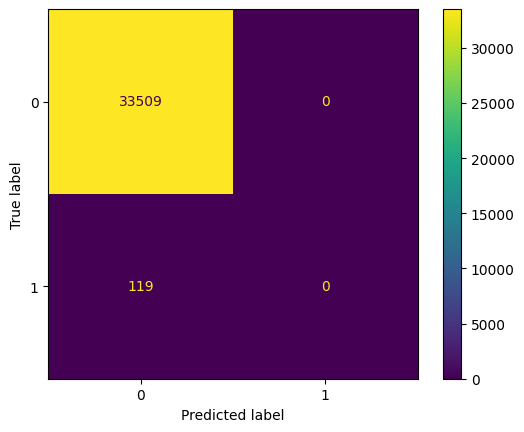

In [19]:
path_to_model = path + "model_lgb_yfinance_aucoptimize.txt"
gbm = lgb.Booster(model_file=path_to_model)

y_pred = gbm.predict(x_test)
y_pred_binary = np.round(y_pred)

accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)

ConfusionMatrixDisplay(confusion).plot()

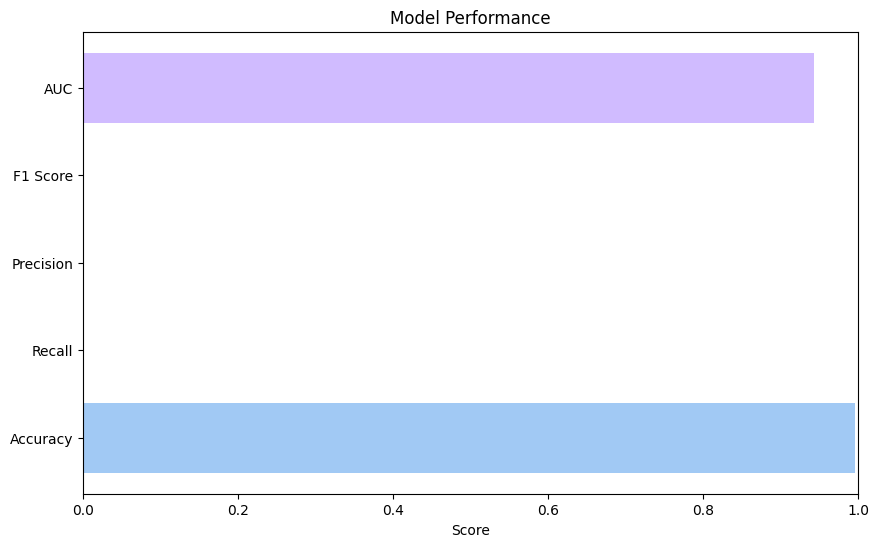

In [20]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [21]:
importance = pd.DataFrame({'feature': x_train.columns, 'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

                        feature  importance
19          net_working_capital        1544
20                   debt_ratio        1283
31     working_capital_turnover        1254
21         debt_to_equity_ratio        1188
15              DTDmedianNonFin        1186
26               asset_turnover        1131
10                          m2b        1110
25             return_on_assets        1019
6                    ni2talevel         983
22                 equity_ratio         969
11                        sigma         906
1                         STInt         902
8                     sizelevel         902
43                       macd_s         885
5                liqnonfintrend         875
42                       macd_h         868
17                  quick_ratio         853
41                         macd         845
4                liqnonfinlevel         834
28            days_in_inventory         832
38  debt_service_coverage_ratio         803
24            net_profit_margin 

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


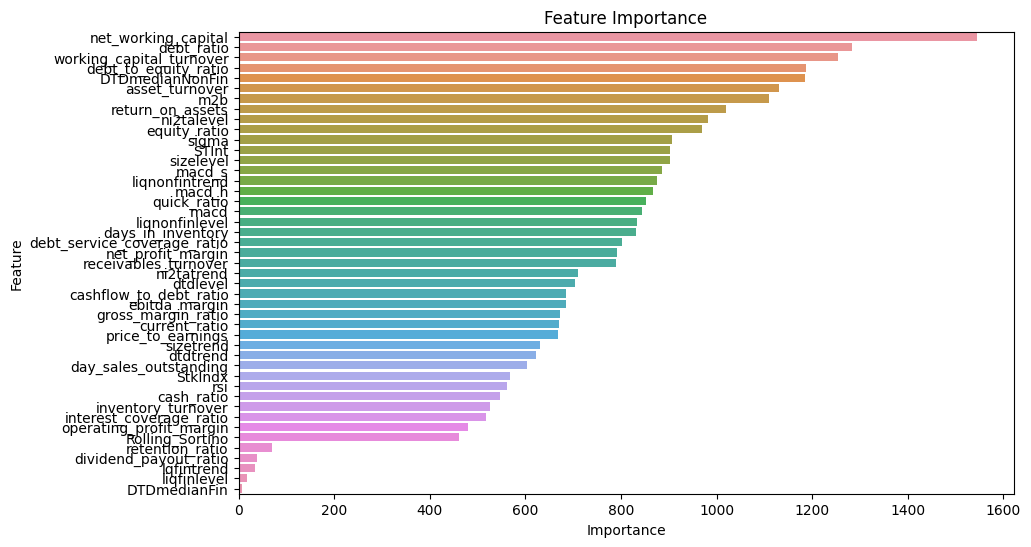

In [22]:
feature_importance = gbm.feature_importance()
features = x_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

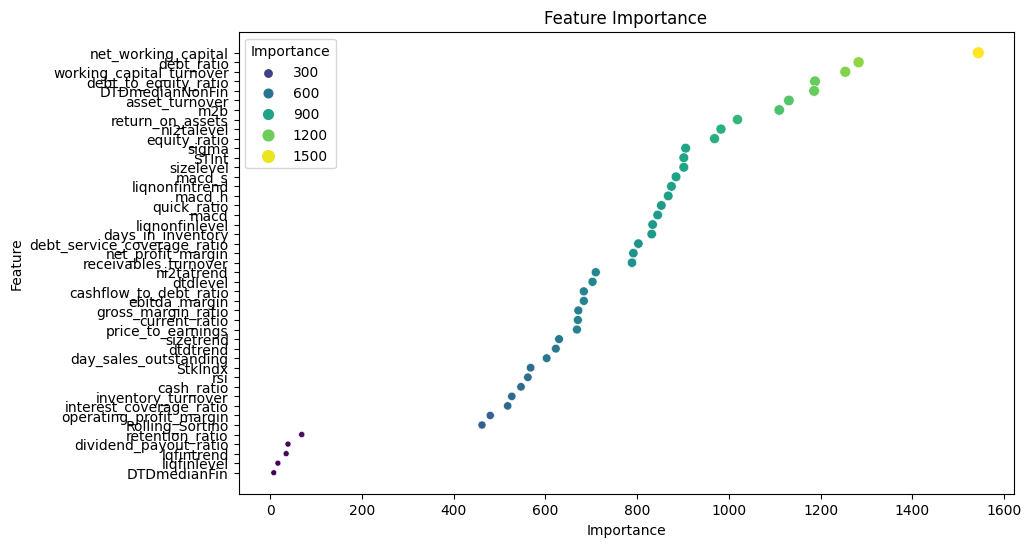

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False), size='Importance', hue='Importance', palette='viridis')
plt.title('Feature Importance')
plt.show()

Load 3 models and compare performances
